In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /dados01/workspace/ufmg.m07dcc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import requests
import random
import json
import requests
import pandas as pd
from tqdm import tqdm
from math import ceil
import matplotlib.pyplot as plt
from datetime import datetime
from elasticsearch import Elasticsearch
from rake_nltk import Rake
import string
es = Elasticsearch()
from collections import Counter
from random import randint
import gc
import uuid
QUERY_NUM = 50

### Utils

In [3]:
def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

def format_query(query):
    query = replace_all(query, {"['": "", "']": "", "'": ""})
    query = query.lower() 
    query = " ".join(query.split())
    return query

def extract_term(query_dict):
    query = ""
    for key, value in query_dict.items():
        if type(value) == dict:
            value = value.get("label", "")
            value = str(value) if value else ""
            query += " " + value
    return query

def load_query_json(entry):
    entry = replace_all(entry, {'""': '"', '"{': '{', '}"': '}'})
    return json.loads(entry)

def process_query_dict(row):
    try:
        entry = load_query_json(row)
        query = extract_term(entry)
        query = format_query(query)
        return query
    except:
        return ''

## Motivação

In [4]:
queries = ['Ação', 'Ação civil pública', 'Ação originária', 'Ação cautelar', 'Ação rescisória', 'Ação trabalhista', 'Acidente de trabalho', 'Acórdão', 'Acordo', 'Agravo', 'agravo de instrumento', 'agravo de petição', 'Alçada', 'A quo', 'Arbitragem', 'Arquivado', 'Arquivo provisório', 'Audiência de instrução e julgamento', 'Autônomo', 'Autos', 'Autuação', 'Aviso-prévio', 'Avulso', 'Bis in idem', 'Caput', 'CTPS', 'Carga', 'Carta precatória', 'Carta rogatória', 'Carta de sentença', 'Celetista', 'Consolidado', 'Certidão de objeto e pé', 'Certificado digital', 'Citação', 'Coisa julgada', 'Cipa', 'CNDT', 'Comissão de Conciliação Prévia', 'Conciliação', 'Composição', 'Conclusos', 'Conflito de competência', 'Contrarrazões', 'Contribuição sindical ', 'Assistencial', 'Confederativa', 'Cooperativa', 'Correição', 'Custas', 'DSR', 'Decadência', 'Décimo terceiro salário', 'Decisão interlocutória', 'Declaração de pobreza', 'Desembargador', 'Deserção', 'Despacho', 'Dilação', 'Diligência', 'Dissídio', 'Dissídio coletivo', 'Dissídio individual', 'Distribuição', 'Edital', 'E-doc', 'Efeito suspensivo', 'Embargos', 'de declaração', 'à execução que', 'de terceiro', 'Ementa', 'Empregado', 'Empregador', 'Execução', 'Ex nunc', 'Ex officio', 'Exordial', 'Ex tunc', 'Estatutário', 'FAT', 'Férias', 'FGTS', 'Foro', 'Gorjeta', 'GRU', 'Habeas corpus', 'Habeas data', 'Hasta Pública', 'Homologação', 'Honorários', 'Hora extra', 'Impedimento', 'Instância', 'grau de jurisdição', 'Intempestivo', 'Jornada de trabalho', 'Juiz', 'Juiz classista', 'Jurisdição', 'Jurisprudência', 'Juros de mora', 'Jus postulandi', 'Justa causa', 'Justiça gratuita', 'Laudo', 'Leilão judicial', 'Licitação', 'Lide', 'Liminar', 'Liquidação', 'Litigante de má fé', 'Litisconsórcio', 'Litispendência', 'Lockout', 'Mandado judicial', 'Mandado de segurança', 'Medida cautelar', 'Mérito da ação', 'Ministério do Trabalho', 'Ministério Público do Trabalho', 'Normas regulamentares', 'Notificação', 'Obreiro', 'Oficial de justiça', 'Ônus da prova', 'Orientação jurisprudencial', 'Ouvidoria', 'PAT', 'Parecer', 'Partes', 'Penhora', 'Perícia', 'Petição', 'Plantão judiciário', 'Portaria', 'Praça pública', 'Precad', 'Precatório', 'Preliminar', 'Preposto', 'Prescrição', 'Prioridade', 'Processo', 'Processos pendentes', 'Procuração', 'ad judicia', 'Protelatório', 'Procrastinatório', 'Provimento', 'PJe-JT', 'Recesso', 'Reclamado', 'Reclamante', 'Recolhimento previdenciário', 'Recurso ordinário', 'Recurso', 'ex officio', 'Redução a termo', 'Relator', 'Relatório', 'Responsabilidade solidária', 'Subsidiária', 'Revelia', 'Revisor', 'Rito', 'Rito ou procedimento sumário', 'Rito ou procedimento sumaríssimo', 'Salário', 'Segredo de justiça', 'Seguro desemprego', 'Sentença', 'Sessão de julgamento', 'Sindicato', 'Sisdoc', 'Sobrestado', 'Sobreaviso', 'Substabelecimento', 'Sucumbência', 'Súmula', 'Suspeição', 'Sustentação oral', 'SRTE', 'Testemunha', 'Transação', 'Trânsito em julgado', 'Turma', 'Tutela', 'Ulterior', 'Vara do Trabalho', 'Vínculo empregatício', 'Voto']

In [5]:
len(queries)

192

## Consultas baseadas em auto complete

### Termos completos

In [6]:
# http://www.mpf.mp.br/es/sala-de-imprensa/glossario-de-termos-juridicos
# https://transparencia.campogrande.ms.gov.br/downloads/glossario-de-termos/

# https://www.mpmg.mp.br/data/files/DD/D1/9F/BD/8B44A7109CEB34A7760849A8/MPMG%20para%20jornalistas.pdf
# glossario do proprio mpmg ainda não explroado

In [7]:
glos1 = ["A contento",  "Abertura de falência",  "Abolitio criminis",  "Ab-rogação",  "Abuso de autoridade",  "Abuso de poder",  "Ação",  "Ação cautelar",  "Ação cível originária",  "Ação civil pública",  "Ação de execução",  "Ação de improbidade administrativa",  "Ação de jurisdição voluntária",  "Ação de reintegração de posse",  "Ação declaratória",  "Ação Declaratória de Constitucionalidade (ADC)",  "Ação Direta de Inconstitucionalidade (ADI)",  "Ação penal",  "Ação popular",  "Ação regressiva",  "Ação rescisória",  "Acautelar",  "Acórdão",  "Ad argumentandum tantum",  "Ad cautelam",  "Ad hoc",  "Ad nutum",  "Ad referendum",  "ADCT",  "Adição da denúncia",  "Aditamento",  "Administração Pública",  "Advocacia administrativa",  "Advogado dativo ou assistente judiciário",  "Advocacia-Geral da União",  "Agravo",  "Agravo de instrumento",  "Agravo retido",  "Ajuizar",  "Alvará de soltura",  "Amicus curiae",  "Anistia",  "Antecipação de tutela",  "Anulação",  "Apelação",  "Arbitragem",  "Aresto",  "Argüição de Descumprimento de Preceito Fundamental (ADPF) –",  "Argüição de Inconstitucionalidade –",  "Argüição de suspeição –",  "Arresto",  "Assistência judiciária",  "Ato administrativo",  "Ato jurídico",  "Audiência pública",  "Autarquia",  "Auto-acusação falsa",  "Auto-executoriedade administrativa",  "Autos",  "Autuação",  "Baixa dos autos",  "Bem inalienável",  "Bem público",  "Bens dominiais",  "Bens imóveis",  "Bens públicos",  "Bens semoventes",  "Bis in idem",  "Bitributação",  "Busca e apreensão",  "Cabo eleitoral",  "Caducar",  "Calúnia",  "Câmaras de Coordenação e Revisão",  "Capacidade civil",  "Capacidade processual",  "Carta precatória",  "Carta rogatória",  "Cidadania",  "Citação",  "Cláusula leonina",  "Cláusula pétrea",  "Cláusulas exorbitantes",  "Coação",  "Coisa julgada",  "Comarca",  "Common law",  "Competência",  "Concessa venia",  "Concorrência pública",  "Concussão",  "Condescendência criminosa",  "Conflito de competência",  "Conselho Nacional de Justiça",  "Conselho Nacional do Ministério Público",  "Consumidor",  "Contencioso",  "Contencioso administrativo",  "Contenda",  "Contrabando",  "Contraditório",  "Contrafração",  "Contravenção",  "Contribuição de melhoria",  "Contribuição social",  "Corpus juris civilis",  "Correição parcial",  "Corrupção ativa",  "Corrupção passiva",  "Crime",  "Crime culposo",  "Crime de responsabilidade",  "Crime doloso",  "Crime hediondo",  "Crime político",  "Custos legis",  "Dano material",  "Dano moral",  "Data venia",  "De facto",  "De jure",  "Decadência",  "Decisão",  "Decisão interlocutória",  "Decisão judicial",  "Decisão monocrática",  "Deferir",  "Demanda",  "Denegar",  "Denúncia",  "Denunciação caluniosa",  "Denunciação da lide",  "Deportação",  "Deprecada",  "Deprecado",  "Deprecante",  "Deprecar",  "Derrogação",  "Desacato",  "Desaforamento",  "Descaminho",  "Despacho",  "Detração",  "Difamação",  "Dilação",  "Diligência",  "Direito de petição",  "Direitos coletivos",  "Direitos difusos",  "Direitos individuais homogêneos",  "Divisas",  "Dolo",  "Domínio público",  "Doutrina",  "Duplo grau de jurisdição",  "Economicidade",  "Edital",  "Efeito suspensivo",  "Embargos",  "Embargos à execução",  "Embargos de declaração",  "Embargos de divergência",  "Embargos de terceiro",  "Embargos infringentes",  "Ementa",  "Emolumento",  "Empresas de economia mista",  "Empresa pública",  "Enriquecimento ilícito",  "Entrância",  "Erga omnes",  "Estado de defesa",  "Estado de Direito",  "Estado de emergência",  "Estado de sítio",  "Estágio confirmatório ou estágio probatório",  "Estelionato",  "Ex nunc",  "Ex officio",  "Ex tunc",  "Ex vi legis",  "Exação",  "Exceção da verdade",  "Exceção de suspeição",  "Exceptio veritatis",  "Excesso de exação",  "Excesso de poder",  "Expulsão",  "Extemporâneo",  "Extra petita",  "Extradição",  "Extrajudicial",  "Facultas agendi",  "Falso testemunho",  "Feito",  "Flagrante delito",  "Foro especial ou privilegiado",  "Fraude processual",  "Freios e contrapesos",  "Fumus boni juris",  "Função jurisdicional",  "Garantia constitucional",  "Golpe de Estado",  "Grau de jurisdição",  "Grau de parentesco",  "H",  "Habeas corpus",  "Habeas data",  "Hipossuficiente",  "Homicídio",  "Homicídio culposo",  "Homicídio doloso",  "Homicídio qualificado",  "Homologação",  "Impeachment",  "Impetrar",  "Imprescritível",  "Improbidade",  "Improbidade administrativa",  "Improbus litigator",  "Impugnar",  "Imunidade",  "In casu",  "In pari causa",  "In rem verso",  "In verbis",  "Inaudita altera par",  "Inamovibilidade",  "Incapacidade",  "Incapacidade civil",  "Incidente de uniformização de jurisprudência",  "Incompetência",  "Inconstitucionalidade",  "Independência funcional",  "Indiciar",  "Indivisibilidade",  "Infraconstitucional",  "Infligir –",  "Injunção",  "Injúria",  "Inquérito",  "Inquérito Civil Público",  "Instância",  "Interdição",  "Interesses coletivos ou difusos",  "Interpelação judicial",  "Intervenção federal",  "Instrução",  "Intimação",  "Isonomia",  "Juiz togado",  "Juiz classista",  "Juizados especiais",  "Julgamento",  "Jure et facto",  "Júri",  "Juris tantum",  "Jurisdição",  "Jurisprudência",  "Justiça Federal",  "Lato sensu",  "Lavrar",  "Legítima defesa",  "Lei",  "Lei marcial",  "Lei Orgânica do Ministério Público da União",  "Leis excepcionais",  "Leis temporárias",  "Lex legum",  "Libelo",  "Liberdade assistida",  "Liberdade condicional",  "Liberdade de pensamento",  "Liberdade de reunião",  "Liberdade política",  "Liberdade provisória",  "Licenciamento ambiental",  "Licitação",  "Lide",  "Liminar",  "Litis contestatio",  "Litisconsórcio",  "Litisconsorte",  "Locupletamento",  "Ma-fé",  "Malversação",  "Mandado",  "Mandado de busca e apreensão",  "Mandado de citação",  "Mandado de injunção",  "Mandado de segurança",  "Mandamus",  "Mandato",  "Manifestação",  "Manutenção de posse",  "Medida cautelar",  "Medida de segurança",  "Medida disciplinar",  "Medida liminar",  "Mens legis",  "Mérito",  "Meritum causae",  "Minervae suffragium",  "Ministério Público",  "Ministério Público da União",  "Ministério Público do Distrito Federal e Territórios",  "Ministério Público do Trabalho",  "Ministério Público Federal",  "Ministério Público Militar",  "Modus operandi",  "Mutatis mutandis",  "Negativa de autoria",  "Negligência",  "Nepotismo",  "Nexo causal",  "Non bis in idem",  "Norma",  "Notificação",  "Notícia-crime",  "Notitia criminis",  "Nulidade",  "Numerus apertus",  "Numerus clausus",  "OAB",  "Obligatio faciendi",  "Obligatio non faciendi",  "Occasio legis",  "Oficial de Justiça",  "Ofício",  "Onus probandi",  "Paciente",  "Parecer",  "Pari passu",  "Parquet",  "Parte",  "Patrimônio público",  "Pátrio poder",  "Peças",  "Peculato",  "Pedido",  "Pedido de reconsideração",  "Periculum in mora",  "Permissa venia",  "Pessoas jurídicas de direito privado",  "Pessoas jurídicas de direito público externo",  "Pessoas jurídicas de direito público interno",  "Petição",  "Plágio",  "Plebiscito",  "Poder constituinte",  "Poder de polícia",  "Polícia judiciária",  "Prazo dilatório",  "Precário",  "Precatória",  "Precatório",  "Preclusão",  "Prejudicado",  "Preliminar",  "Preposto",  "Prescrição",  "Prescrição da pretensão punitiva",  "Presunção",  "Pretório",  "Prevaricação",  "Prevenção",  "Prima facie",  "Princípio da individualização da pena",  "Princípio do devido processo legal",  "Princípios",  "Prisão em flagrante",  "Prisão especial",  "Prisão preventiva",  "Prisão preventiva para extradição",  "Prisão temporária",  "Privilegium fori",  "Privilegium immunitatis",  "Procedimento administrativo",  "Processo",  "Processo administrativo",  "Procurador do Estado",  "Procurador federal",  "Procurador da República",  "Procurador de Justiça",  "Procurador do Distrito Federal",  "Procurador-geral da República",  "Procurador regional da República",  "Procuradoria da República",  "Procuradoria Federal dos Direitos do Cidadão",  "Procuradoria Geral da República",  "Procuradoria Regional da República",  "Proferir",  "Prolação",  "Promotor",  "Promotor natural",  "Protelar",  "Provas",  "Provimento",  "Quadrilha",  "Qualificação do crime",  "Queixa",  "Queixa-crime",  "Qui tacet, consentire videtur",  "Quinto constitucional",  "Quorum",  "Reclamação",  "Reclusão",  "Recomendação",  "Reconvenção",  "Recurso",  "Recurso especial",  "Recurso extraordinário",  "Recurso ordinário criminal",  "Recurso ordinário em habeas corpus",  "Referendo",  "Reincidência",  "Reintegração",  "Relator",  "Relatório",  "Remição de pena",  "Representação",  "Repristinação",  "Res judicata",  "Res judicata pro veritate habetur lat",  "Responsabilidade civil",  "Revel",  "Revelia",  "Revisão criminal",  "Revisor",  "Segredo de Justiça",  "Sentença",  "Seqüestro",  "Sine qua non",  "Sigilo funcional",  "Sonegar",  "Stricto sensu",  "STF",  "STJ",  "Sub judice",  "Suborno",  "Subprocurador-geral da República",  "Sucumbência",  "Súmula",  "Superveniência",  "Sursis",  "Suspeição",  "Suspensão de segurança",  "Taxa",  "Tergiversação",  "Termo de Ajustamento de Conduta",  "Tipicidade",  "Tipo penal",  "Título executivo",  "Tráfico internacional de pessoas",  "Tráfico de influência",  "Transação penal",  "Transitar em julgado",  "Tribunal do júri",  "Tribunal Regional Federal",  "Tributo",  "Turpis causa",  "Tutela",  "Tutela antecipada",  "Última instância",  "Ultra petita",  "Una voce",  "Única instância",  "Unidade",  "Uniformização de jurisprudência",  "Usucapião",  "Usufruto",  "Usura",  "Usurpação",  "Vacatio legis",  "Vara",  "Vênia",  "Verbi gratia (v.g.)",  "Vista",  "Violação de sigilo funcional",  "Violência arbitrária",  "Voto",  "Writ",  "Zona eleitoral"]
glos2 = ["Abertura de Crédito Adicional", "Ação Governamental", "Adimplente", "Adjudicação", "Administração Direta", "Administração Financeira", "Administração Indireta", "Administrador Público", "Ad valorem", "Ajuste", "Alíquota", "Amortização de Empréstimo", "Anulação do Empenho", "Aplicações Diretas", "Arquivado", "Arrecadação", "Atividade (orçamento)", "Atividade Econômica", "Ativo", "Ativo Circulante", "Ativo Compensado", "Ativo Financeiro", "Ativo Líquido", "Ativo Patrimonial", "Ativo Permanente", "Ativo Realizável a Longo Prazo", "Autarquia", "Autarquia de Regime Especial", "Baixado", "Balanço", "Balanço patrimonial", "Beneficiário", "Cadastro de Fornecedores", "Cadastro Único", "Cancelado", "Cargo ou Emprego", "Cartão de Pagamento do Governo Federal", "Chamamento Público", "Ciclo Orçamentário", "Classe", "CNAE (Classificação Nacional de Atividade Econômica)", "CNPJ (Cadastro Nacional de Pessoas Jurídicas)", "Cobertura Orçamentária", "Competência Tributária", "Compra", "Concedente", "Concluído", "Concorrência", "Concurso", "Conta Contábil", "Contragarantia", "Contrapartida", "Contratado", "Contrato", "Contratante", "Contrato de repasse", "Controle Social", "Convenente", "Convênio", "Convite", "Cotação de preços", "CPF (Cadastro de Pessoas Físicas)", "Data Base", "Decreto", "Decreto-Lei", "Déficit", "Déficit Financeiro", "Déficit Orçamentário", "Déficit Orçamentário Bruto", "Déficit Patrimonial", "Déficit Primário", "Denúncia", "Descentralização de Crédito", "Descentralização de Recursos Financeiros", "Despesa Empenhada", "Despesa Liquidada", "Despesa Paga", "Despesa Pública", "Despesas Correntes", "Despesas de Capital", "Despesas de Custeio", "Destaque de Crédito", "DF - Documento de Arrecadação de Receitas Federais (DARF)", "Dispensa de Licitação", "Dívida Ativa", "Dívida Consolidada", "Dívida Fundada Pública", "Dívida Flutuante Pública", "Dívida Não Consolidada", "Dívida Pública", "Dívida Pública Externa", "Dotação", "DR - Documento de Arrecadação dos Estados e Municípios (DAR)", "Elemento de Despesa", "Empenho", "Empresa Pública", "Encargos Especiais", "Encargos de Financiamento", "Encargos Previdenciários da União", "Encargos Sociais", "Entidade sem fins lucrativos", "Entidade Vinculada", "Espelho da Despesa", "Espelho da Receita", "Estágios da Despesa", "Estágios da Receita", "Estimativa da Receita", "Etapa", "Excesso de Arrecadação", "Excluído", "Execução Financeira", "Execução Orçamentária da Despesa", "Executor", "Exercício Financeiro", "Exercícios Anteriores", "Fato Gerador", "Favorecidos", "Fim da Vigência (convênio)", "FL - Folha de Pagamento", "Função", "Função ou Cargo de Confiança", "Fundação Pública", "Fundo", "Fundos de Participação", "Fundo de Participação dos Estados (FPE)", "Fundo de Participação dos Municípios (FPM)", "Gestão", "Gestor", "GF - Guia de Recolhimento do FGTS e de Informações à Previdência Social", "GP - Guia de Recolhimento da Previdência Social", "GR - Guia de Recolhimento da União", "Grupo de Despesa", "Guia de Recebimento (GR)", "Homologação", "Impostos", "Inadimplência Suspensa", "Inadimplente", "Incentivo Fiscal", "Indicadores Econômicos", "Inexigibilidade de licitação", "Ingressos Públicos ou Entradas", "Interveniente", "Inversões Financeiras", "Investimentos", "Isenção", "Janela Orçamentária", "Lançamento", "Lei de Licitações", "Lei de Diretrizes Orçamentárias (LDO)", "Lei de Responsabilidade Fiscal", "Lei de Meios", "Leilão", "Lei Orçamentária Anual (LOA)", "Liberação de Cotas", "Licitação", "Linguagem Cidadã", "Liquidação", "Localização", "Lotação", "Mandatário", "Material de Consumo", "Material Permanente", "Medição", "Medida Provisória", "Ministério", "Modalidade de Aplicação", "Multa", "Natureza da Despesa", "NE - Nota de Empenho", "NIS (Número de Identidade Social)", "NL - Nota de Lançamento", "Nome Fantasi", "Nota de Dotação", "Nota de Empenho", "Nota de Lançamento", "Nota de Previsão de Receita", "NS - Nota de Lançamento de Sistema", "Número do convênio", "OB - Ordem Bancária", "Objeto", "Objeto do Convênio", "Objeto de Gasto", "Obra", "Obrigações Patronais", "Oferta pública (competitiva)", "On Line", "Opção Parcial", "Operação de Crédito", "Orçamento Base-Zero", "Orçamento de Desempenho", "Orçamento Fiscal", "Orçamento Incremental", "Orçamento de Investimento", "Orçamento da Seguridade Social", "Orçamento Programa", "Orçamento Público", "Orçamento Sem Teto Fixo", "Orçamento SEST", "Orçamento com Teto Fixo", "Orçamento com Teto Móvel", "Orçamento Tradicional", "Ordem Bancária", "Ordenador de Despesa", "Órgão", "Órgão Central", "Órgão Setorial", "Órgãos Autônomos", "Órgão de Exercício", "Órgãos Independentes", "Órgão de Lotação", "Órgãos Superiores", "Outras Despesas de Capital", "Outras Despesas Correntes", "Padrão", "Padronização", "Pagamento", "Pagamentos de Sentenças Judiciárias", "Passivo", "Passivo Circulante", "Passivo Compensado", "Patrimônio", "Patrimônio Líquido", "Patrimônio Público", "Pessoa Física", "Pessoa Jurídica", "Pessoal e Encargos Sociais", "Planejamento", "Plano Plurianual", "Portal da Transparência", "Pregão Eletrônico", "Prestação de Contas", "Previsão", "Previsão Orçamentária", "Programas de Governo", "Programa de Trabalho", "Projeto", "Projeto Básico", "Projeto Executivo", "Proposta Orçamentária", "Provisão", "Publicação (convênio)", "Receita", "Receita - Arrecadação", "Receitas Correntes", "Receitas de Capital", "Receita Extra Orçamentária", "Receita Lançada", "Receita - Lançamento", "Receita Orçamentária", "Receita Ordinária", "Receita Originária", "Receita - Previsão", "Receita Própria", "Receita Pública", "Receita - Recolhimento", "Regime de Caixa", "Regime de Competência", "Regime Jurídico", "Registro", "Rescindido", "Seguridade Social", "Sistema Integrado de Administração de Serviços Gerais (SIASG)", "Sistema de Gestão de Convênios (SICONV)", "Sistema Integrado de Administração Financeira do Governo Federal (SIAFI)", "Sistema Integrado de Dados Orçamentários (SIDOR)", "Sistema Integrado de Administração de Recursos Humanos (SIAPE)", "Sistema de Contas", "Sistema de Contas de Compensação", "Sistema de Contas Financeiro", "Sistema de Contas Orçamentário", "Sistema Orçamentário", "Sistema Patrimonial", "Situação Vínculo", "Sociedade de Economia Mista", "Sub-Repasse", "Subsídio", "Subvenção Econômica", "Subvenção Social", "Superávit Financeiro", "Superávit Orçamentário", "Suprimento de Fundos", "Taxa", "Termo Aditivo", "Termo de Cooperação", "Títulos da Dívida Pública", "Tomada de Contas", "Tomada de Contas Especial", "Tomada de Preços", "Transferências Correntes", "Transferências de Capital", "Transferências ao Exterior", "Tributo", "Unidade Administrativa", "Unidade Aplicadora", "Unidade Gestora", "Unidade Gestora Executora", "Unidade Gestora Responsável", "Unidade Orçamentária", "Universalidade do Orçamento", "Unidade Transferidora", "Valor do Convênio", "Valor da Contrapartida (convênio)", "Valor Liberado (convênio)", "Valor Última Liberação (convênio)"]
queries = list(set(glos1 + glos2))
print(f"Quantidade de termos {len(queries)}")

Quantidade de termos 781


### Palavras individuais que formam os termos

In [8]:
new_candidates = []
for query in queries:
    new_candidates += query.split()

new_candidates = list(set(new_candidates))
print(f"Quantidade de termos {len(set(new_candidates))}")

Quantidade de termos 964


### Submissão para auto-completar

In [9]:
candidates = queries + new_candidates
candidates = list(set(candidates))
print(f"Quantidade total de candidatos {len(set(candidates))}")

Quantidade total de candidatos 1478


In [10]:
auto_complete_queries = []
for query in tqdm(candidates):
    content = requests.get(f"https://autocomplete-br-endpoint.jusbrasil.com.br/ajax/autocomplete/?q={query}")
    content = content.text
    for new_query in json.loads(content):
        auto_complete_queries.append(new_query["titulo"].replace("<b>", "").replace("</b>", ""))

100%|█████████████████████████████████████████████████████████████████████████████| 1478/1478 [02:12<00:00, 11.15it/s]


In [11]:
auto_complete_queries = list(set(auto_complete_queries))
auto_complete_queries_df = pd.DataFrame(auto_complete_queries)
auto_complete_queries_df.sample(5)

,0
10919,inexigibilidade do título executivo judicial
1753,princípio da legalidade
3231,crime contra a administração pública
1266,ordenador de despesa possibilidade
6904,contrabando pedido de restituição


In [12]:
print(f"Quantidade total de consultas geradas {len(auto_complete_queries_df)}")

Quantidade total de consultas geradas 11433


Possíveis melhorias na estrateǵia:
- Inclusão de termos relacionados a outros temas
- Filtragem da lista do glossário original para escolher termos princiais, com supervisão do MPMG
- Filtragem da lista final de consultas geradas, para remover referências a localizações fora de Minas Gerais
- Casamento das consultas geradas com nomes e possíveis entidades

## Consultas baseadas nos logs

In [42]:
df = pd.read_csv("../sistemasgsi_set21_202110121608.csv")

In [43]:
df.head()

,id_log,dsc_log,ind_tipo,dat_criacao,id_usuario,id_sistema,dsc_rota
0,8364099,"""{""""id"""":""""5a3510bd-0a42-4182-a902-394c96752c2...",ERRO,2021-09-28 15:48:10.153555,4383.0,1.0,/aduna/busca
1,8364127,"""{""""id"""":""""2491f00d-59a1-44e8-8c05-d2d62293ec8...",ACESSO,2021-09-28 15:49:24.389905,692.0,1.0,/aduna/busca/4675724/1/
2,8364147,"""{""""id"""":""""c5fc8118-aedb-4fe7-8500-90cc2a23141...",ERRO,2021-09-28 15:49:31.418554,2873.0,1.0,/aduna/busca
3,8364171,"""{""""filtros"""":[{""""tudo"""":""""\""""17890481\""""""""}],...",ACESSO,2021-09-28 15:50:03.658545,3664.0,1.0,/aduna/busca/
4,8364197,"""{""""id"""":""""38c76dab-854f-40c1-a42f-dc4ad8babfe...",ERRO,2021-09-28 15:50:55.54138,3310.0,1.0,/aduna/busca


###  Consultas dos logs do Áduna

In [44]:
desc_rota_aduna = [rota for rota in list(df["dsc_rota"].unique()) if "aduna" in str(rota)]
df_aduna = df[df["dsc_rota"].isin(desc_rota_aduna)]
df_aduna = df_aduna[df_aduna["ind_tipo"] == "ACESSO"]

logs_aduna = []
for idx, row in tqdm(df_aduna.iterrows(), total = len(df_aduna)):
    try:
        logs_aduna.append(load_query_json(row["dsc_log"])["nome_pessoa"])
    except:
        pass

100%|██████████████████████████████████████| 2334810/2334810 [03:31<00:00, 11047.95it/s]


In [45]:
df_aduna = pd.DataFrame(logs_aduna, columns=["query"])
df_aduna["query"]

0                       MARCO PAULO GONCALVES
1                      ANTONIO LESSA TEIXEIRA
2                    LILIAN LOPES DE OLIVEIRA
3                           MAXIUEL JUVENTINO
4                            RONY CARLOS DIAS
                         ...                 
617564                DENILSON ALMEIDA AMORIM
617565               VIOLETA RIBEIRO DA SILVA
617566    ANIANGELA APARECIDA DA SILVA VELOSO
617567      LUIZ GUILHERME DE CAMPOS FERREIRA
617568               WEDSON SOARES DE QUEIROZ
Name: query, Length: 617569, dtype: object

In [46]:
print(f"Quantidade total de consultas geradas {len(df_aduna['query'])}")

Quantidade total de consultas geradas 617569


###  Consultas dos logs do Lins

In [47]:
desc_rota_lins = [rota for rota in list(df["dsc_rota"].unique()) if "lins" in str(rota)]
df_lins = df[df["dsc_rota"].isin(desc_rota_lins)]
df_lins = df_lins[df_lins["ind_tipo"] == "ACESSO"]
df_lins["query"] = df_lins["dsc_log"].apply(process_query_dict)
df_lins = df_lins[df_lins["query"] != ""]
df = []
gc.collect()

15077

In [48]:
df_lins["query"]

1635          comarca tupaciguara araporã 07.638.816/0001-94
1644          comarca tupaciguara araporã 07.638.816/0001-94
1653          comarca tupaciguara araporã 07.638.816/0001-94
1654       comarca tupaciguara araporã 2016, 2015 07.638....
1662          comarca tupaciguara araporã 07.638.816/0001-94
                                 ...                        
7647259    estado minas gerais todos municípios 03.260.61...
7647260    estado minas gerais todos municípios 03.260.61...
7647269    estado minas gerais todos municípios 03.260.61...
7647270    estado minas gerais vargem alegre 2018 03.260....
7647310    estado minas gerais todos municípios 03.260.61...
Name: query, Length: 62547, dtype: object

In [49]:
print(f"Quantidade total de consultas geradas {len(df_lins['query'])}")

Quantidade total de consultas geradas 62547


# Geração do conjunto final de consultas

In [13]:
# old
# final_queries = []
# while len(final_queries) < QUERY_NUM:
#     query_sample = QUERY_NUM - len(final_queries)
#     random.shuffle(auto_complete_queries)
#     auto_complete_querie_sample = auto_complete_queries[:ceil(query_sample / 2)]
#     logs_queries_sample = list(df_lins["query"].sample(ceil(query_sample / 4))) + list(df_aduna["query"].sample(ceil(query_sample / 4)))
#     final_queries += list(set(logs_queries_sample + auto_complete_querie_sample))
#     final_queries = [query for query in final_queries if query]
    
# final_queries = final_queries[:QUERY_NUM]

In [18]:
final_queries = []
while len(final_queries) < QUERY_NUM:
    query_sample = QUERY_NUM - len(final_queries)
    print(len(final_queries))
    random.shuffle(auto_complete_queries)

    auto_complete_querie_sample = auto_complete_queries[:ceil(query_sample / 2)]
    auto_complete_querie_sample = [{"query": q, "origin": "auto_complete", "id": str(uuid.uuid4())} for q in auto_complete_querie_sample]
    
    logs_queries_sample_lins = list(df_lins["query"].sample(ceil(query_sample / 4)))
    logs_queries_sample_aduna = list(df_aduna["query"].sample(ceil(query_sample / 4)))
    logs_queries_sample_lins = [{"query": q, "origin": "lins", "id": str(uuid.uuid4())} for q in logs_queries_sample_lins]
    logs_queries_sample_aduna = [{"query": q, "origin": "aduna", "id": str(uuid.uuid4())} for q in logs_queries_sample_aduna]    
    logs_queries_sample = logs_queries_sample_lins + logs_queries_sample_aduna

    final_queries += {v['query']:v for v in logs_queries_sample + auto_complete_querie_sample}.values()
    final_queries = [q for q in final_queries if q["query"]]
    
final_queries = final_queries[:QUERY_NUM]

0
25
38
44
47
49


In [19]:
final_queries

[{'query': 'secretaria de estado de defesa social seap',
  'origin': 'auto_complete',
  'id': 'c1815f55-167c-405f-b241-7e8937a5cf23'},
 {'query': 'fumus boni iuris',
  'origin': 'auto_complete',
  'id': '12406ff7-c18d-4877-8315-6fa04ec3b2b2'},
 {'query': 'causalidade adequada',
  'origin': 'auto_complete',
  'id': '38ff53de-7e90-4dbb-b912-40a8c8c63de4'},
 {'query': 'liberdade condicional',
  'origin': 'auto_complete',
  'id': '344bfd96-e0ae-45ca-a7f8-6033c18010ae'},
 {'query': 'estado do rio grande do sul',
  'origin': 'auto_complete',
  'id': 'beb8119d-3e30-40b9-9cdc-85c30349dc4a'},
 {'query': 'superavit gestao empresarial ltda',
  'origin': 'auto_complete',
  'id': '2ab3e92c-47cb-4c2a-a4af-05ff2c50f72d'},
 {'query': 'ingressos show restituição lei',
  'origin': 'auto_complete',
  'id': '9653dc68-3d3a-4451-af6f-52af58deb9a4'},
 {'query': 'base de cálculo dos honorários sucumbenciais',
  'origin': 'auto_complete',
  'id': '474714e2-4496-483b-a208-9d36af56186d'},
 {'query': 'absolvição 

In [20]:
len(final_queries)

50

# Caracterização

In [21]:
queries_df = pd.DataFrame(final_queries, columns=["query", "origin"])
queries_df = queries_df.dropna()
queries_df["len"] = queries_df["query"].apply(lambda x: len(x.split()))
queries_df.sample(10)

,query,origin,len
43,dispensa abusiva e arbitrária,auto_complete,4
46,agentes políticos salário,auto_complete,3
5,superavit gestao empresarial ltda,auto_complete,4
48,excesso de exação principio da insignificancia,auto_complete,6
37,medicamentos e honorários advocatícios,auto_complete,4
4,estado do rio grande do sul,auto_complete,6
18,planos de saúde,auto_complete,3
45,autos arquivados provisoriamente,auto_complete,3
19,pedra lançada,auto_complete,2
7,base de cálculo dos honorários sucumbenciais,auto_complete,6


In [22]:
print(queries_df["len"].median())
print(queries_df["len"].mean())

4.0
4.58


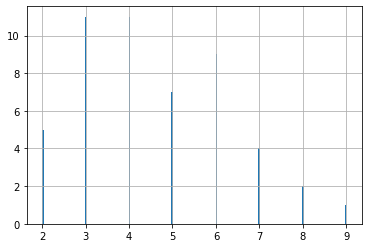

In [23]:
queries_df["len"].hist(bins=200)
plt.show()

In [24]:
print(f"Quantidade de consultas com até 3 termos: {sum(queries_df['len'] < 4)}")
print(f"Quantidade de consultas com até 4 termos: {sum(queries_df['len'] < 5)}")
print(f"Quantidade de consultas com até 5 termos: {sum(queries_df['len'] < 6)}")
print(f"Quantidade de consultas com até 6 termos: {sum(queries_df['len'] < 7)}")

Quantidade de consultas com até 3 termos: 16
Quantidade de consultas com até 4 termos: 27
Quantidade de consultas com até 5 termos: 34
Quantidade de consultas com até 6 termos: 43


In [25]:
with open("generated_queries.txt", "w") as fout:
    fout.write(str(final_queries))